# Access Database-Files to explore and summerise Data

In [1]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [2]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [4]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2017-02-22/data eval new/"
file_name = "int_norm_20170222_bgd_new_den.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [6]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [7]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [8]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

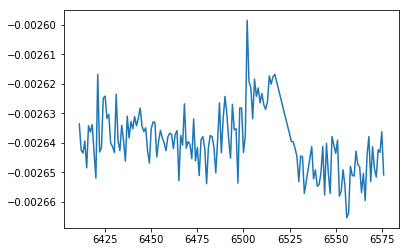

In [9]:
# Check Baselines
column = "117"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

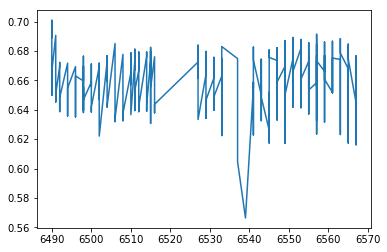

In [10]:
# Check Signals
column = "122"
sample = "NIST 40ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

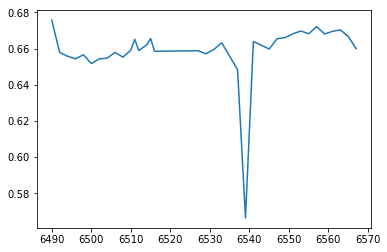

In [11]:
# Check Signals - mean
column = "122"
sample = "NIST 40ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

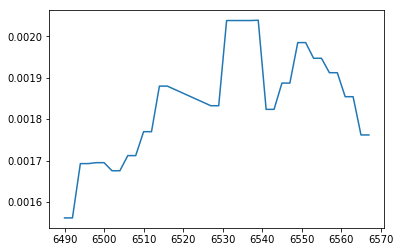

In [12]:
# Check background 
column = "118"
sample = "NIST 40ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [13]:
background_mean = df_mean(background)

# Outlier rejection

In [45]:
bgd_method = "bgd_outlier_corr"
norm_ratio = "r_118_120"
interf_corr = "Te126_Xe129_corr"

In [46]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [47]:
column = "124/120"
sample = "NIST 40ppb"

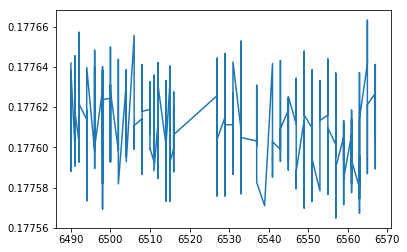

In [48]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [49]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [50]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2017-02-23 11:27:00,NIST 5.5ppb,2,1,6412,NaN,NaN,0.010343,0.445908,0.235299,0.742935,0.263523,0.142165,0.177586
2017-02-23 11:27:00,NIST 5.5ppb,2,2,6412,0.029807,0.020161,0.010331,0.445875,0.235329,0.742935,0.263528,0.142144,0.177681
2017-02-23 11:27:00,NIST 5.5ppb,2,3,6412,0.029856,0.020139,0.010372,0.446066,0.235396,0.742935,0.263574,0.142062,0.177569
2017-02-23 11:27:00,NIST 5.5ppb,2,4,6412,0.029824,0.020172,0.010348,0.445918,0.235333,0.742935,0.263560,0.142103,0.177667
2017-02-23 11:27:00,NIST 5.5ppb,2,5,6412,0.029774,0.020126,0.010328,0.445855,0.235344,0.742935,0.263513,0.142169,0.177641
2017-02-23 11:27:00,NIST 5.5ppb,2,6,6412,0.029795,0.020183,0.010337,0.445821,NaN,0.742935,0.263586,0.142225,0.177746
2017-02-23 11:27:00,NIST 5.5ppb,2,7,6412,0.029807,0.020144,0.010322,0.445992,0.235350,0.742935,0.263520,0.142053,0.177518
2017-02-23 11:27:00,NIST 5.5ppb,2,8,6412,0.029859,0.020185,0.010372,0.446016,0.235356,0.742935,0.263528,0.142109,0.177577
2017-02-23 11:27:00,NIST 5.5ppb,2,9,6412,0.029806,0.020195,0.010295,0.446041,0.235325,0.742935,0.263590,0.142118,0.177564


In [51]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
6415        2017-02-23 12:07:00    0.187082
            2017-02-23 12:07:00    0.186942
            2017-02-23 12:07:00    0.187069
            2017-02-23 12:07:00    0.186969
            2017-02-23 12:07:00    0.187106
6420        2017-02-23 13:12:00    0.187099
6426        2017-02-23 14:29:00    0.186930
6440        2017-02-23 17:35:00    0.186965
6443        2017-02-23 18:15:00    0.187208
6454        2017-02-23 20:37:00    0.187168
            2017-02-23 20:37:00    0.187154
6458        2017-02-23 21:30:00    0.187045
6467        2017-02-23 23:31:00    0.187126
6486        2017-02-24 03:39:00    0.186974
6514        2017-02-24 09:44:00    0.187356
6528        2017-02-24 12:37:00    0.187524
6541        2017-02-24 16:17:00    0.187199
6546        2017-02-24 17:24:00    0.187320
            2017-02-24 17:24:00    0.187308
6549        2017-02-24 18:04:00    0.187213
6553        2017-02-24 18:57:00    0.187255
6559        2017-02-24 20:17:00    0.187254


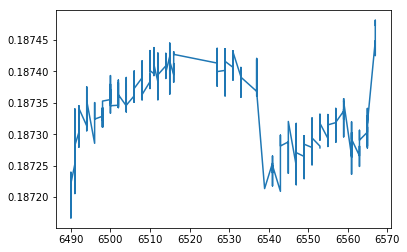

In [52]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [53]:
df[df["Sample"] == sample][column].std()

6.167277664816633e-05

In [54]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

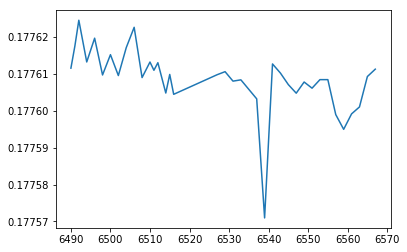

In [55]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [56]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,
2017-02-23 11:27:00,6412,NIST 5.5ppb,0.029812,0.020176,0.010347,0.445957,0.235340,0.742935,0.263551,0.142117,0.177599
2017-02-23 11:52:00,6414,NIST 5.5ppb,0.029808,0.020180,0.010339,0.445960,0.235348,0.742935,0.263544,0.142090,0.177595
2017-02-23 12:07:00,6415,NIST 5.5ppb,0.029792,0.020193,0.010316,0.445916,0.235357,0.742935,0.263551,0.142124,0.177619
2017-02-23 12:19:00,6416,NIST 5.5ppb,0.029844,0.020211,0.010359,0.445974,0.235339,0.742935,0.263551,0.142135,0.177573
2017-02-23 12:45:00,6418,NIST 5.5ppb,0.029824,0.020232,0.010343,0.445929,0.235344,0.742935,0.263545,0.142115,0.177625
2017-02-23 12:59:00,6419,NIST 5.5ppb,0.029844,0.020258,0.010354,0.445909,0.235351,0.742935,0.263553,0.142131,0.177659
2017-02-23 13:12:00,6420,NIST 5.5ppb,0.029816,0.020216,0.010343,0.445953,0.235382,0.742935,0.263544,0.142075,0.177590
2017-02-23 13:37:00,6422,NIST 5.5ppb,0.029858,0.020248,0.010367,0.446009,0.235365,0.742935,0.263563,0.142094,0.177589
2017-02-23 13:51:00,6423,NIST 5.5ppb + 0.3ppb Mo,0.029868,0.020256,0.010368,0.446003,0.235378,0.742935,0.263543,0.142102,0.177569


In [57]:
date_list = [pd.Timestamp('2017-02-24 15:53:00')]
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [58]:
drop_sum = [pd.Timestamp('2017-02-23 20:12:00'), 
            pd.Timestamp('2017-02-24 00:09:00'), 
            pd.Timestamp('2017-02-24 05:38:00'), 
            pd.Timestamp('2017-02-23 17:22:00')]

In [59]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [60]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [61]:
data_mean_int_sum

112/120                       114/120  \
                              mean           SD2 count      mean   
Sample                                                             
J.W. Leach 1b             0.029818           NaN     1  0.020181   
J.W. Leach 2a             0.029793           NaN     1  0.020179   
J.W. Leach 5b             0.029818           NaN     1  0.020188   
NIST 40ppb                0.029821  1.128742e-05    36  0.020192   
NIST 40ppb + 0.002ppb U   0.029823  4.360467e-06     2  0.020194   
NIST 40ppb + 0.1ppb Zr    0.029818  2.342655e-07     2  0.020188   
NIST 40ppb + 0.2ppb Ru    0.029816  9.697828e-06     2  0.020187   
NIST 40ppb + 0.5ppb Pd    0.029817           NaN     1  0.020187   
NIST 40ppb + 2.5ppb Mo    0.029820  7.816188e-06     2  0.020194   
NIST 5.5ppb               0.029827  7.747671e-05    23  0.020201   
NIST 5.5ppb + 0.024 Te    0.029777           NaN     1  0.020081   
NIST 5.5ppb + 0.1ppb Ru   0.029826  2.847730e-05     2  0.020200   
NIST 5.5ppb + 0.3ppb Mo   0.029868           NaN     1  0.020256   
NIST 5.5ppb + Te          0.029828           NaN     1  0.020205   
NIST 9ppb                 0.029820  6.293858e-05    26  0.020188   
NIST 9ppb + 0.05ppb Te    0.029789           NaN     1  0.020149   
NIST 9ppb +0.1ppb Ru      0.029794           NaN     1  0.020171   
NIST 9ppb +0.3ppb Mo      0.029839  4.390634e-05     2  0.020221   
ZH09-05 23.3_3b_3 35ppb   0.029821           NaN     1  0.020194   
ZH09-05 23.3_3b_3 5.5ppb  0.029868           NaN     1  0.020270   
ZH09-05 23.3_3b_3 9ppb    0.029815           NaN     1  0.020190   

                                               115/120                  \
                                   SD2 count      mean       SD2 count   
Sample                                                                   
J.W. Leach 1b                      NaN     1  0.010364       NaN     1   
J.W. Leach 2a                      NaN     1  0.010376       NaN     1   
J.W. Leach 5b                      NaN     1  0.010357       NaN     1   
NIST 40ppb                1.276505e-05    36  0.010359  0.000004    36   
NIST 40ppb + 0.002ppb U   2.648849e-07     2  0.010359  0.000004     2   
NIST 40ppb + 0.1ppb Zr    7.124491e-06     2  0.010361  0.000001     2   
NIST 40ppb + 0.2ppb Ru    9.666677e-06     2  0.010363  0.000004     2   
NIST 40ppb + 0.5ppb Pd             NaN     1  0.010362       NaN     1   
NIST 40ppb + 2.5ppb Mo    1.066399e-06     2  0.010358  0.000003     2   
NIST 5.5ppb               8.447611e-05    23  0.010355  0.000035    23   
NIST 5.5ppb + 0.024 Te             NaN     1  0.010361       NaN     1   
NIST 5.5ppb + 0.1ppb Ru   7.983323e-05     2  0.010357  0.000003     2   
NIST 5.5ppb + 0.3ppb Mo            NaN     1  0.010368       NaN     1   
NIST 5.5ppb + Te                   NaN     1  0.010334       NaN     1   
NIST 9ppb                 6.652685e-05    26  0.010361  0.000018    26   
NIST 9ppb + 0.05ppb Te             NaN     1  0.010362       NaN     1   
NIST 9ppb +0.1ppb Ru               NaN     1  0.010362       NaN     1   
NIST 9ppb +0.3ppb Mo      2.330357e-05     2  0.010369  0.000007     2   
ZH09-05 23.3_3b_3 35ppb            NaN     1  0.010362       NaN     1   
ZH09-05 23.3_3b_3 5.5ppb           NaN     1  0.010372       NaN     1   
ZH09-05 23.3_3b_3 9ppb             NaN     1  0.010354       NaN     1   

                           116/120  ...  118/120   119/120                  \
                              mean  ...    count      mean       SD2 count   
Sample                              ...                                      
J.W. Leach 1b             0.445889  ...        1  0.263555       NaN     1   
J.W. Leach 2a             0.445884  ...        1  0.263507       NaN     1   
J.W. Leach 5b             0.446013  ...        1  0.263490       NaN     1   
NIST 40ppb                0.445980  ...       36  0.263504  0.000009    36   
NIST 40ppb + 0.002ppb U   0.445974  ...        2  0.263512  0.000003   

In [62]:
epsilon_int_5 = SSB(data_mean_int, "NIST 5.5ppb", 10000)
delta_raw_5 = SSB(data_mean_raw, "NIST 5.5ppb", 1000)
epsilon_int_9 = SSB(data_mean_int, "NIST 9ppb", 10000)
delta_raw_9 = SSB(data_mean_raw, "NIST 9ppb", 1000)
epsilon_int_40 = SSB(data_mean_int, "NIST 40ppb", 10000)
delta_raw_40 = SSB(data_mean_raw, "NIST 40ppb", 1000)

In [63]:
#date_list = [pd.Timestamp('2016-06-24 11:14:00'), 
#             pd.Timestamp('2016-06-24 12:02:00'), 
#             pd.Timestamp('2016-06-24 12:26:00'),
#             pd.Timestamp('2016-06-24 15:57:00'),
#             pd.Timestamp('2016-06-24 19:26:00'),
#             pd.Timestamp('2016-06-24 23:16:00')]

#date_list = []

#epsilon_int_sub = epsilon_int.drop(date_list)
#delta_raw_sub = delta_raw.drop(date_list)

In [64]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -1) & (df["Filenumber"] <= 1)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [65]:
epsilon_int_5 = epsilon_process(epsilon_int_5)
delta_raw_5 = epsilon_process(delta_raw_5)
epsilon_int_9 = epsilon_process(epsilon_int_9)
delta_raw_9 = epsilon_process(delta_raw_9)
epsilon_int_40 = epsilon_process(epsilon_int_40)
delta_raw_40 = epsilon_process(delta_raw_40)

#epsilon_2 = epsilon_2[(epsilon_2["Filenumber"] >= -1) & (epsilon_2["Filenumber"] <= 1)]

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [66]:
epsilon_int_5 = epsilon_int_5.drop([pd.Timestamp('2017-02-23 20:12:00'), pd.Timestamp('2017-02-23 20:37:00')])
epsilon_int_9 = epsilon_int_9.drop([pd.Timestamp('2017-02-23 21:05:00'), pd.Timestamp('2017-02-24 00:09:00'), pd.Timestamp('2017-02-24 01:29:00')])
epsilon_int_40 = epsilon_int_40.drop([pd.Timestamp('2017-02-24 15:18:00')])
delta_raw_5 = delta_raw_5.drop([pd.Timestamp('2017-02-23 20:12:00'), pd.Timestamp('2017-02-23 20:37:00')])
delta_raw_9 = delta_raw_9.drop([pd.Timestamp('2017-02-23 21:05:00'), pd.Timestamp('2017-02-24 00:09:00'), pd.Timestamp('2017-02-24 01:29:00')])
delta_raw_40 = delta_raw_40.drop([pd.Timestamp('2017-02-24 15:18:00')])

In [67]:
epsilon_int_40

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2017-02-24 04:46:00,6491,-0.894935,-0.317312,2.793293,-0.090181,0.020570,0.000000e+00,0.345009,0.121863,-0.028573,NIST 40ppb
2017-02-24 04:58:00,6492,1.101742,-0.792546,-2.644798,0.113799,0.056479,0.000000e+00,-0.294670,0.207428,0.515467,NIST 40ppb
2017-02-24 05:24:00,6494,0.126529,2.498424,2.922927,0.022367,-0.038645,0.000000e+00,0.041074,-0.386315,-0.499927,NIST 40ppb
2017-02-24 05:38:00,6495,-4.699247,-2.563322,11.709307,-0.095647,-0.402718,2.220446e-12,-0.168250,0.688330,0.515756,NIST 9ppb
2017-02-24 05:51:00,6496,0.013377,-0.557687,-1.024967,-0.033357,-0.019853,0.000000e+00,0.090631,0.220645,0.462245,NIST 40ppb
2017-02-24 06:16:00,6498,-0.862758,-1.209086,-2.253504,-0.153182,-0.125041,2.220446e-12,-0.188310,-0.130456,-0.435570,NIST 40ppb
2017-02-24 06:31:00,6499,0.965200,-0.018356,0.422275,0.206149,0.064211,-1.110223e-12,-0.196319,-0.496925,-0.208940,NIST 40ppb + 2.5ppb Mo
2017-02-24 06:43:00,6500,-0.227597,1.635346,2.179558,0.126258,0.199240,0.000000e+00,0.275045,0.135278,0.314215,NIST 40ppb
2017-02-24 07:08:00,6502,0.695600,-1.683744,0.461646,0.154542,-0.002592,-3.330669e-12,-0.186931,-0.167393,-0.372626,NIST 40ppb


In [68]:
epsilon_int_5_sum = np.round(epsilon_int_5.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_5_sum = np.round(delta_raw_5.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_int_9_sum = np.round(epsilon_int_9.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_9_sum = np.round(delta_raw_9.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_int_40_sum = np.round(epsilon_int_40.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_40_sum = np.round(delta_raw_40.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

#epsilon_sum_2 = np.round(epsilon_2.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_sum_all = epsilon_int_5_sum.append([epsilon_int_9_sum, epsilon_int_40_sum])
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_5_sum.append([delta_raw_9_sum, delta_raw_40_sum])
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [70]:
epsilon_sum_all

112/120               114/120               115/120  \
                            mean     SD2 count    mean     SD2 count    mean   
Sample                                                                         
J.W. Leach 1b            -10.981     NaN     1  -7.990     NaN     1  -9.480   
NIST 5.5ppb                0.203  29.783    21   0.788  51.437    21  -0.035   
NIST 5.5ppb + 0.024 Te    -9.407     NaN     1 -36.481     NaN     1  -0.605   
NIST 5.5ppb + 0.1ppb Ru   -2.473   0.863     2   6.549  14.057     2   7.095   
NIST 5.5ppb + 0.3ppb Mo   -0.818     NaN     1  -3.499     NaN     1  -3.969   
NIST 5.5ppb + Te           3.684     NaN     1  12.322     NaN     1   0.881   
NIST 9ppb                 -0.654     NaN     1   9.195     NaN     1  -5.470   
ZH09-05 23.3_3b_3 5.5ppb   2.626     NaN     1  24.871     NaN     1   2.150   
J.W. Leach 2a            -10.632     NaN     1  -6.723     NaN     1  17.879   
NIST 40ppb                -2.542     NaN     1   5.940     NaN     1   2.284   
NIST 5.5ppb              -22.154     NaN     1 -16.434     NaN     1  21.488   
NIST 9ppb                 -0.599  10.013    19  -0.174  23.590    19   0.472   
NIST 9ppb + 0.05ppb Te    -9.703     NaN     1 -12.230     NaN     1   6.987   
NIST 9ppb +0.1ppb Ru     -10.662     NaN     1 -16.013     NaN     1   9.026   
NIST 9ppb +0.3ppb Mo       5.829  11.768     2  15.413  17.969     2   0.331   
ZH09-05 23.3_3b_3 9ppb    -1.390     NaN     1  -9.534     NaN     1  -7.821   
J.W. Leach 5b              0.249     NaN     1  -1.270     NaN     1  -3.681   
NIST 40ppb                -0.012   2.794    29   0.159   4.953    29   0.117   
NIST 40ppb + 0.002ppb U   -0.016   0.183     2   0.311   1.826     2   1.338   
NIST 40ppb + 0.1ppb Zr    -1.627   0.451     2  -3.760   0.058     2   1.769   
NIST 40ppb + 0.2ppb Ru    -0.830   0.717     2  -2.409   3.470     2   2.434   
NIST 40ppb + 0.5ppb Pd    -2.501     NaN     1  -4.169     NaN     1   0.995   
NIST 40ppb + 2.5ppb Mo    -0.173   3.219     2  -0.679   1.869     2  -0.236   
NIST 9ppb                  2.088  19.197     2   2.291  13.729     2   4.296   
ZH09-05 23.3_3b_3 35ppb   -3.755     NaN     1  -4.245     NaN     1   3.473   

                                       116/120  ...  118/120 119/120         \
                             SD2 count    mean  ...    count    mean    SD2   
Sample                                          ...                           
J.W. Leach 1b                NaN     1  -2.905  ...        1   1.218    NaN   
NIST 5.5ppb               42.616    21   0.029  ...       21   0.016  1.467   
NIST 5.5ppb + 0.024 Te       NaN     1  -0.294  ...        1  -1.408    NaN   
NIST 5.5ppb + 0.1ppb Ru    1.891     2   0.660  ...        2   0.178  1.077   
NIST 5.5ppb + 0.3ppb Mo      NaN     1   0.011  ...        1   0.012    NaN   
NIST 5.5ppb + Te             NaN     1  -0.485  ...        1  -0.418    NaN   
NIST 9ppb                    NaN     1   0.600  ...        1   0.028    NaN   
ZH09-05 23.3_3b_3 5.5ppb     NaN     1  -0.254  ...        1  -0.550    NaN   
J.W. Leach 2a                NaN     1  -1.182  ...        1  -0.023    NaN   
NIST 40ppb                   NaN     1   0.946  ...        1   0.154    NaN   
NIST 5.5ppb                  NaN     1  -0.705  ...        1  -0.653    NaN   
NIST 9ppb                 19.981    19  -0.085  ...       19   0.122  1.707   
NIST 9ppb + 0.05ppb Te       NaN     1  -0.069  ...        1   0.278    NaN   
NIST 9ppb +0.1ppb Ru         NaN     1  -0.451  ...        1   0.513    NaN   
NIST 9ppb +0.3ppb Mo      25.639     2   0.566  ...        2  -0.400  0.804   
ZH09-05 23.3_3b_3 9ppb       NaN     1  -0.324  ...        1  -0.920    NaN   
J.W. Leach 5b                NaN     1   0.674  ...        1  -0.446    NaN   
NIST 40ppb                 5.350    29  -0.006  ...       29   0.011  0.374   
NIST 40ppb + 0.002ppb U    3.054     2   0.006  ...        2   0.268  0.290   
NIST 40ppb + 0.1ppb Zr     4.405     2   0.198

In [39]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_5.append([epsilon_int_9, epsilon_int_40]), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_5.append([delta_raw_9, delta_raw_40]), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [40]:
#hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw']

# Raw data to xls file

In [91]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [92]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [41]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_new_den.xlsx', engine='xlsxwriter')


In [42]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_5.append([epsilon_int_9, epsilon_int_40]).to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_5.append([delta_raw_9, delta_raw_40]).to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [43]:
writer_orig.save()

In [44]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [334]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')